In [1]:
import numpy as np
import pandas as pd
import os
import io
import seaborn as sns
import requests
import json

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy
import scipy.stats as stats
import scipy.optimize as opt
#import statsmodels.api as sm

from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated, Mixture
import theano.tensor as tt 
from pymc3.distributions.distribution import Continuous, draw_values, generate_samples

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
plt.style.use('seaborn-darkgrid')
pd.set_option('display.max_columns', 500)
%matplotlib inline 

In [2]:
data = pd.read_csv("data/combined_seasons.csv")

In [3]:
data.head()

,Unnamed: 0,Assist1,Assist1_ID,Assist2,Assist2_ID,Assists2_ID,Away,Away_Score,EmptyNet,Event,EventID,Event_Description,Event_Team,Event_Type_ID,Final_Away_Score,Final_Home_Score,GameDate,GameID,GameState,GameType,Goalie,Goalie_ID,Home,Home_Score,Period,Period_Type,Player_1_ID,Player_1_Name,Player_2_ID,Player_2_Name,Scorer,Scorer_ID,Shooter,Shooter_ID,ShotType,Time_Remaining,Time_in_Period,Venue,x,y,Side,Season,y_stdz,x_stdz,y_normal,x_normal,Event_Team_Adj,y_same,x_same,zone_x,zone_y,shot_zone,Opposition Team,Shifted_Event_Type_ID,Shifted_shot_zone,Shifted_Time_Remaining,Event_Time_Difference,Shot_Context
0,0,None,None,None,NaN,None,Vancouver Canucks,0,None,Game Scheduled,1,Game Scheduled,None,GAME_SCHEDULED,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,None,None,None,None,None,None,None,None,None,1900-01-01 00:20:00,00:00,STAPLES Center,NaN,NaN,NaN,2017-2018,NaN,NaN,NaN,NaN,None,NaN,NaN,Other,NaN,Other,Los Angeles Kings,NaN,NaN,NaN,NaN,Non-Shot Event
1,1,None,None,None,NaN,None,Vancouver Canucks,0,None,Period Ready,54,Period Ready,None,PERIOD_READY,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,None,None,None,None,None,None,None,None,None,1900-01-01 00:20:00,00:00,STAPLES Center,NaN,NaN,NaN,2017-2018,NaN,NaN,NaN,NaN,None,NaN,NaN,Other,NaN,Other,Los Angeles Kings,GAME_SCHEDULED,Other,1900-01-01 00:20:00,0.0,Non-Shot Event
2,2,None,None,None,NaN,None,Vancouver Canucks,0,None,Period Start,2,Period Start,None,PERIOD_START,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,None,None,None,None,None,None,None,None,None,1900-01-01 00:20:00,00:00,STAPLES Center,NaN,NaN,NaN,2017-2018,NaN,NaN,NaN,NaN,None,NaN,NaN,Other,NaN,Other,Los Angeles Kings,PERIOD_READY,Other,1900-01-01 00:20:00,0.0,Non-Shot Event
3,3,None,None,None,NaN,None,Vancouver Canucks,0,None,Faceoff,3,Markus Granlund faceoff won against Adrian Kempe,Vancouver Canucks,FACEOFF,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,8476440,Markus Granlund,8477960,Adrian Kempe,None,None,None,None,None,1900-01-01 00:20:00,00:00,STAPLES Center,0.0,0.0,left,2017-2018,0.0,0.0,-0.0,-0.0,Vancouver Canucks,-0.0,-0.0,Other,Center,Other,Los Angeles Kings,PERIOD_START,Other,1900-01-01 00:20:00,0.0,Non-Shot Event
4,4,None,None,None,NaN,None,Vancouver Canucks,0,None,Penalty,57,Adrian Kempe Hooking against Philip Holm,Los Angeles Kings,PENALTY,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,8477960,Adrian Kempe,8480163,Philip Holm,None,None,None,None,Hooking,1900-01-01 00:19:41,00:19,STAPLES Center,11.0,36.0,right,2017-2018,36.0,11.0,-36.0,-11.0,Los Angeles Kings,36.0,11.0,Other,Right Board,Other,Vancouver Canucks,FACEOFF,Other,1900-01-01 00:20:00,19.0,Non-Shot Event


In [4]:
hurricanes = data[(data['GameType'] == 'R') & (data['Event_Type_ID'] == 'GOAL') & (data['EmptyNet'] != 'True') & (data['Period'] != 4) & (data['Period'] != 5) & ((data['Away'] == 'Carolina Hurricanes') | (data['Home'] == 'Carolina Hurricanes'))].reset_index()

In [5]:
hurricanes['Period'].unique()

array([1, 2, 3])

In [6]:
canes_games = hurricanes[['Event_Type_ID', 'Home', 'Away', 'Period', 'GameID', 'Event_Team', 'GameDate', 'Season','Final_Away_Score', 'Final_Home_Score']]

In [7]:
canes_games['Opponent'] = canes_games['Event_Team'].apply(lambda x: x if x == 'Carolina Hurricanes' else 'Opponent')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
grouped = canes_games[['GameID', 'Opponent', 'Period']].groupby(['GameID', 'Opponent']).count().reset_index()

In [9]:
grouped = grouped.groupby(['GameID', 'Opponent'])['Period'].aggregate('mean').unstack().reset_index().fillna(0)

In [10]:
game_info = canes_games[['GameID', 'Final_Away_Score', 'Final_Home_Score', 'Home', 'Away', 'GameDate', 'Season']].drop_duplicates()

In [11]:
game_data = game_info.merge(grouped, on='GameID', how='inner')

In [12]:
game_data['GoalDiff'] = game_data['Carolina Hurricanes'] - game_data['Opponent']

In [13]:
df_2018 = game_data[game_data['Season'] == '2017-2018']
df_2019 = game_data[game_data['Season'] == '2018-2019']

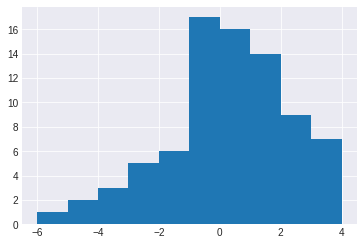

In [14]:
df_2018['GoalDiff'].hist()

In [15]:
with pm.Model() as model:
    
    #Pooled Parameters
    mu_normal = pm.Uniform('mu_normal', lower=-10.0, upper=10.0)
    sd_normal = pm.Uniform('sd_normal', lower=0.5, upper=6)
    #nu_t = pm.Uniform('nu_normal', lower=1, upper=100)
    
    likelihood = pm.Normal('likelihood', mu=mu_normal, sd=sd_normal, observed=df_2018['GoalDiff'].values)
    #y_est = pm.Normal('y_est', mu=mu_normal, sd=sd_normal)
    
    trace = pm.sample(10000, cores=-1, tune=2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 12500/12500 [00:11<00:00, 1073.21it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41a90ec048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f41a8ffb908>]], dtype=object)

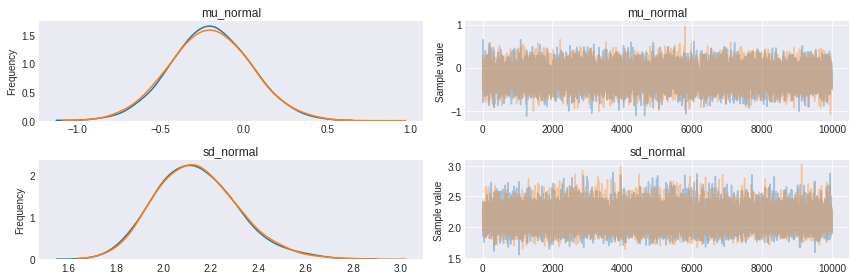

In [16]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f41a8fe8cf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f41a874fc18>], dtype=object)

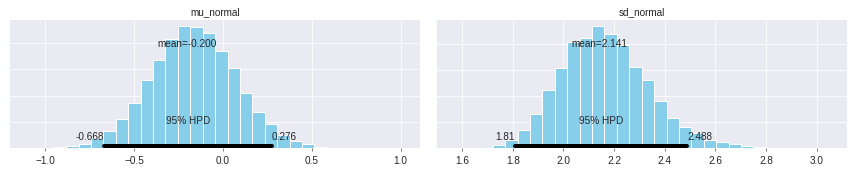

In [17]:
pm.plot_posterior(trace)

In [18]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    
    return Interpolated(param, x, y)

In [19]:
def prob_persona_faster(persona, personb):
    return np.float(sum(np.array(persona) - np.array(personb) > 0))/len(personb)

In [ ]:
probabilities = []
for i in range(0, len(df_2019)):
    for t in range(0, 10):
        try:
            observed = df_2019[0:i+1]['GoalDiff'].values
            with pm.Model() as model:

                #Pooled Parameters
                mu_normal = from_posterior('mu_normal', trace['mu_normal'])
                sd_normal = from_posterior('sd_normal', trace['sd_normal'])

                likelihood = pm.Normal('likelihood', mu=mu_normal, sd=sd_normal, observed=observed)

                trace2 = pm.sample(100000, cores=-1, tune=1000)

            probabilities.append(prob_persona_faster(trace2.get_values('mu_normal'), trace.get_values('mu_normal')))
            break
        except:
            pass

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:06<00:00, 801.06it/s]
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
There were 443 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/101000 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:24<00:00, 697.28it/s]
There were 23108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.213773715278, bu

The acceptance probability does not match the target. It is 0.151954304148, but should be close to 0.8. Try to increase the number of tuning steps.
There were 14352 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.505244864612, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/101000 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:05<00:00, 804.45it/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or re

There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:13<00:00, 755.24it/s]
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:16<00:00, 741.83it/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective sample

100%|██████████| 101000/101000 [02:21<00:00, 714.35it/s]
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:14<00:00, 749.53it/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:11<00:00, 767.51it/s]
There were 19 divergences after tuning. Increase `target_

Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [01:59<00:00, 847.54it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/101000 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:01<00:00, 828.80it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%

100%|██████████| 101000/101000 [02:07<00:00, 792.48it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [01:58<00:00, 851.01it/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:06<00:00, 798.08it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initi

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/101000 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [01:57<00:00, 856.71it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [01:55<00:00, 875.72it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 

100%|██████████| 101000/101000 [01:54<00:00, 882.25it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [03:14<00:00, 519.91it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.955054398015, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.926599728723, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...

100%|██████████| 101000/101000 [01:53<00:00, 890.49it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/101000 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [01:55<00:00, 877.22it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:49<00:00, 594.37it/s]
There were 2 diverg

100%|██████████| 101000/101000 [01:57<00:00, 855.99it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/101000 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [01:53<00:00, 888.17it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [01:57<00:00, 857.57it/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUT

NUTS: [sd_normal, mu_normal]
  0%|          | 0/101000 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:19<00:00, 723.48it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:20<00:00, 720.52it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:27<00:00, 684.11it/s]
There were 4 divergences after tuning. Increase `target_accept` or repara

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:08<00:00, 782.99it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:05<00:00, 804.91it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:18<00:00, 728.00it/s]
There was 1 divergence after tuning. Increase `target_accept` or r

The acceptance probability does not match the target. It is 0.898926403046, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:03<00:00, 820.55it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:00<00:00, 840.30it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:01<00:00, 831.57it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [01:59<00:00, 845.57it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.889758434171, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 101000/101000 [02:01<00:00, 833.14it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
N

In [43]:
len(probabilities)

41

In [50]:
df_2019

,level_0,index,GameID,Final_Away_Score,Final_Home_Score,Home,Away,GameDate,Season,Carolina Hurricanes,Opponent,GoalDiff,Probability,OpposingTeam,Opponent2
0,0,80,2018020008,2,1,Carolina Hurricanes,New York Islanders,2018-10-04,2018-2019,1.0,1.0,0.0,0.50290,New York Islanders,Oct 04 \n New York Islanders
1,1,81,2018020015,3,1,Columbus Blue Jackets,Carolina Hurricanes,2018-10-05,2018-2019,3.0,1.0,2.0,0.53130,Columbus Blue Jackets,Oct 05 \n Columbus Blue Jackets
2,2,82,2018020029,5,8,Carolina Hurricanes,New York Rangers,2018-10-07,2018-2019,7.0,5.0,2.0,0.56955,New York Rangers,Oct 07 \n New York Rangers
3,3,83,2018020037,3,5,Carolina Hurricanes,Vancouver Canucks,2018-10-09,2018-2019,5.0,3.0,2.0,0.59795,Vancouver Canucks,Oct 09 \n Vancouver Canucks
4,4,84,2018020060,5,4,Minnesota Wild,Carolina Hurricanes,2018-10-13,2018-2019,4.0,4.0,0.0,0.60910,Minnesota Wild,Oct 13 \n Minnesota Wild
5,5,85,2018020073,1,3,Winnipeg Jets,Carolina Hurricanes,2018-10-14,2018-2019,1.0,2.0,-1.0,0.59165,Winnipeg Jets,Oct 14 \n Winnipeg Jets
6,6,86,2018020082,2,4,Tampa Bay Lightning,Carolina Hurricanes,2018-10-16,2018-2019,2.0,3.0,-1.0,0.58270,Tampa Bay Lightning,Oct 16 \n Tampa Bay Lightning
7,7,87,2018020103,3,1,Carolina Hurricanes,Colorado Avalanche,2018-10-20,2018-2019,1.0,3.0,-2.0,0.54590,Colorado Avalanche,Oct 20 \n Colorado Avalanche
8,8,88,2018020119,3,1,Detroit Red Wings,Carolina Hurricanes,2018-10-22,2018-2019,2.0,1.0,1.0,0.56835,Detroit Red Wings,Oct 22 \n Detroit Red Wings
9,9,89,2018020146,3,4,Carolina Hurricanes,San Jose Sharks,2018-10-26,2018-2019,3.0,3.0,0.0,0.57305,San Jose Sharks,Oct 26 \n San Jose Sharks


In [44]:
df_2019 = df_2019.reset_index()

In [45]:
df_2019['Probability'] = probabilities

In [46]:
df_2019['OpposingTeam'] = df_2019.apply(lambda row: row['Home'] if row['Home'] != 'Carolina Hurricanes' else row['Away'], axis=1)


In [47]:
df_2019['Opponent2'] =  pd.to_datetime(df_2019['GameDate']).dt.strftime("%b %d") + " \n " + df_2019['OpposingTeam']

In [48]:
df_2019

,level_0,index,GameID,Final_Away_Score,Final_Home_Score,Home,Away,GameDate,Season,Carolina Hurricanes,Opponent,GoalDiff,Probability,OpposingTeam,Opponent2
0,0,80,2018020008,2,1,Carolina Hurricanes,New York Islanders,2018-10-04,2018-2019,1.0,1.0,0.0,0.50290,New York Islanders,Oct 04 \n New York Islanders
1,1,81,2018020015,3,1,Columbus Blue Jackets,Carolina Hurricanes,2018-10-05,2018-2019,3.0,1.0,2.0,0.53130,Columbus Blue Jackets,Oct 05 \n Columbus Blue Jackets
2,2,82,2018020029,5,8,Carolina Hurricanes,New York Rangers,2018-10-07,2018-2019,7.0,5.0,2.0,0.56955,New York Rangers,Oct 07 \n New York Rangers
3,3,83,2018020037,3,5,Carolina Hurricanes,Vancouver Canucks,2018-10-09,2018-2019,5.0,3.0,2.0,0.59795,Vancouver Canucks,Oct 09 \n Vancouver Canucks
4,4,84,2018020060,5,4,Minnesota Wild,Carolina Hurricanes,2018-10-13,2018-2019,4.0,4.0,0.0,0.60910,Minnesota Wild,Oct 13 \n Minnesota Wild
5,5,85,2018020073,1,3,Winnipeg Jets,Carolina Hurricanes,2018-10-14,2018-2019,1.0,2.0,-1.0,0.59165,Winnipeg Jets,Oct 14 \n Winnipeg Jets
6,6,86,2018020082,2,4,Tampa Bay Lightning,Carolina Hurricanes,2018-10-16,2018-2019,2.0,3.0,-1.0,0.58270,Tampa Bay Lightning,Oct 16 \n Tampa Bay Lightning
7,7,87,2018020103,3,1,Carolina Hurricanes,Colorado Avalanche,2018-10-20,2018-2019,1.0,3.0,-2.0,0.54590,Colorado Avalanche,Oct 20 \n Colorado Avalanche
8,8,88,2018020119,3,1,Detroit Red Wings,Carolina Hurricanes,2018-10-22,2018-2019,2.0,1.0,1.0,0.56835,Detroit Red Wings,Oct 22 \n Detroit Red Wings
9,9,89,2018020146,3,4,Carolina Hurricanes,San Jose Sharks,2018-10-26,2018-2019,3.0,3.0,0.0,0.57305,San Jose Sharks,Oct 26 \n San Jose Sharks


[ 0.      0.5029]
[ 1.      0.5313]
[ 2.       0.56955]
[ 3.       0.59795]
[ 4.      0.6091]
[ 5.       0.59165]
[ 6.      0.5827]
[ 7.      0.5459]
[ 8.       0.56835]
[ 9.       0.57305]
[ 10.        0.55875]
[ 11.       0.5518]
[ 12.        0.55255]
[ 13.        0.55545]
[ 14.       0.4878]
[ 15.        0.50455]
[ 16.      0.504]
[ 17.       0.6988]
[ 18.       0.4707]
[ 19.        0.48195]
[ 20.       0.6314]
[ 21.        0.53015]
[ 22.       0.4947]
[ 23.       0.5101]
[ 24.       0.5104]
[ 25.        0.50115]
[ 26.       0.4509]
[ 27.        0.48435]
[ 28.       0.4533]
[ 29.        0.43605]
[ 30.       0.4407]
[ 31.        0.47895]
[ 32.       0.4567]
[ 33.        0.42495]
[ 34.       0.4503]
[ 35.        0.44065]
[ 36.        0.42785]
[ 37.       0.4664]
[ 38.       0.4796]
[ 39.       0.5036]
[ 40.        0.51315]


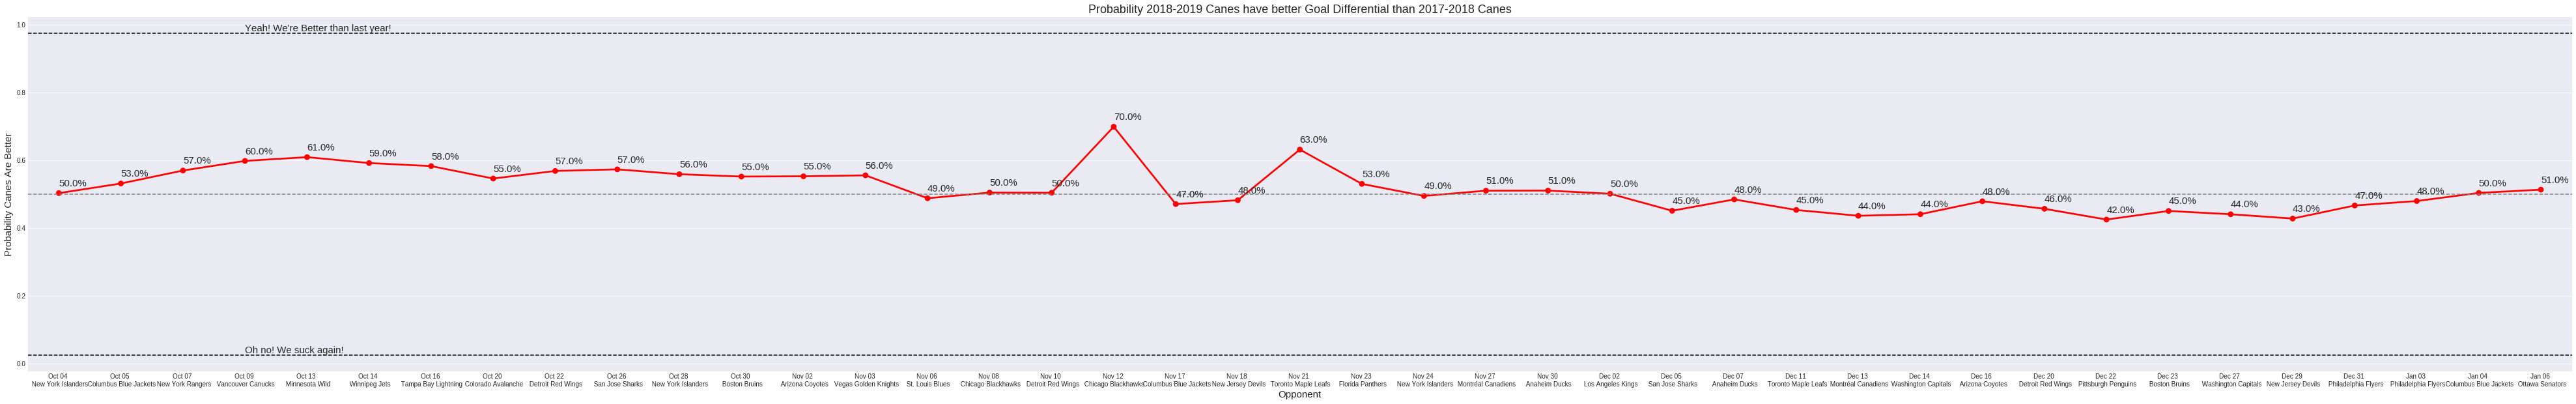

In [49]:
fig, ax = plt.subplots(figsize=(70, 10))
ax.set_title('Probability 2018-2019 Canes have better Goal Differential than 2017-2018 Canes', fontsize=18)
p1 = sns.pointplot(x=df_2019['Opponent2'], y=df_2019['Probability'], color='red')
plt.axhline(.975, color='black', ls='--', label= "Yeah! We're Better than Last Year!")
plt.axhline(.025, color='black', ls='--', label= "Nope We Suck")
plt.axhline(.50, color='grey', ls='--')
p1.set_ylabel('Probability Canes Are Better', fontsize=15)
p1.set_xlabel('Opponent', fontsize=15)
for c in ax.collections:
    for of in c.get_offsets():
        print(of)
        of2 = [of[0], of[1]+0.02]
        ax.annotate('%r' % round(of[1]*100, 0) + "%", of2, size=15)
ax.annotate("Yeah! We're Better than last year!", [3, .98], size=15)
ax.annotate("Oh no! We suck again!", [3, .03], size=15)
plt.show()

In [ ]:
canes_df2['Probabilities'] = probabilities

In [ ]:
canes_df3 = pd.read_csv("Desktop/canes.csv")

In [ ]:
canes_df2.to_csv("canes.csv")